# Reducing Revenue Loss from Hotel Cancelations

## <u>Part 1: Import and Clean Data<u/>

### Import Libraries

Import matplotlib, pandas, numpy, and a few other libraries for use in this analysis.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.dates as md
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np
import datetime
from datetime import date, timedelta
import calendar

### Import Data Sources & Summary of Data

Here I am importing the data as "hotel_bookings" and then taking a look at the summary of the data. 

'Describe' gives as view of some basic statistical information such as count, mean, standard deviation, min/max, and quartile information. 

'Info' gives a list of columns, a count of non-null rows for each column, and the type of entry. 

In [2]:
hotel_bookings = pd.read_csv('Hotel Bookings.csv', header=0)

In [3]:
print(hotel_bookings.describe())

         is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416     104.011416        2016.156554   
std         0.482918     106.863097           0.707476   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             119390.000000              119390.000000   
mean                  27.165173                  15.798241   
std                   13.605138                   8.780829   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%                   38.000000            

In [4]:
print(hotel_bookings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

For the sake of visualization labeling, I'm creating a duplicate column with "Not Canceled / Canceled" instead of "0 / 1"

In [5]:
hotel_bookings['labeled_is_canceled'] = hotel_bookings['is_canceled']
hotel_bookings['labeled_is_canceled'] = hotel_bookings['labeled_is_canceled'].replace(to_replace = 0,value = "Not Canceled")
hotel_bookings['labeled_is_canceled'] = hotel_bookings['labeled_is_canceled'].replace(to_replace = 1,value = "Canceled")

#### Creating a "Cancelation Notice" Column

By creating a column that provides the cancelation notice in days, we can determine how far in advance customers are canceling before their scheduled arrival date. 

Creating this variable requires creating a column in a date format by combining information from columns 'Arrival Date Year', 'Arrival Date Month', and 'Arrival Date Day of Month'. Then, the idea is to find the difference from the new arrival date column and the 'Reservation Status Date' column if reservation status is canceled. 

The first step is to convert the month column to an integer because it's currently an onject with the month's full spelling.

In [6]:
def month_converter(month):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    return months.index(month) + 1

hotel_bookings['arr_month_num'] = hotel_bookings['arrival_date_month'].apply(month_converter)


The second step is to combine the 3 elements of a date with the output of an arrival date column.

In [7]:
date = pd.DataFrame({'year': hotel_bookings['arrival_date_year'],
                   'month': hotel_bookings['arr_month_num'],
                   'day': hotel_bookings['arrival_date_day_of_month']})
hotel_bookings['arrival_date'] = pd.to_datetime(date)

The third step is to convert 'Reservation Status Date' to a datetime.

In [8]:
hotel_bookings['res_status_date'] = pd.to_datetime(hotel_bookings['reservation_status_date'])

The fourth step is to create a new column with the number of days difference between Arrival Date and Status Date if the status is cancelation, otherwise NA.

In [9]:
d1 = hotel_bookings['arrival_date']
d2 = hotel_bookings['res_status_date']
difference_days = abs(d2 - d1)

hotel_bookings['Date Difference'] = difference_days
hotel_bookings['Date Difference'] = hotel_bookings['Date Difference'].dt.days.astype('int64')

Finally check to confirm successful column creation using .info. Success!

In [10]:
print(hotel_bookings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 37 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119386 non-null  float64

**Review: Cancelation Notice -** I created a new column that is actually named "Date Difference". It finds the difference between the arrival date and the date the reservation status is updated. This happens for all rows of data. But, when filtered to those reservations which are canceled, will refer to the amount of time between the date the reservation is canceled to the date that customer should have arrived- essentially, a cancelation notice in days. 

#### Any additional Data Cleaning Should be HERE

## <u> Part 2: Basic Analysis</u>

### Total Count & Canceled/Noncanceled

In [11]:
total_bookings = hotel_bookings['is_canceled'].count()
print(total_bookings)
print(type(total_bookings))

119390
<class 'numpy.int32'>


Our dataset includes 119,390 rows of data; each representing an individual booking.

As a company, we are interested in decreasing cancelations. Therefore, a good first step would be to determine how many of our total bookings end up being canceled. We will create a **bar graph** as well as a **dataframe display of a count and percentage of total bookings** in order to grasp how big of a segment cancelations represent.

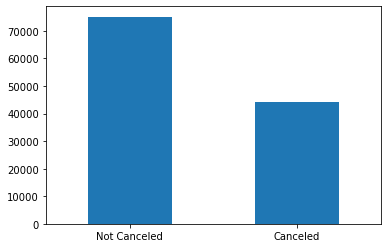

,Count,% of Total
Not Canceled,75166,62.96
Canceled,44224,37.04


In [12]:
#Creating the Bar Graph
ax = hotel_bookings['labeled_is_canceled'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)

plt.show()

#Creating a DataFrame to neatly show Count and Percentage of Total
total_vcount = hotel_bookings['labeled_is_canceled'].value_counts()

df_tvc = pd.DataFrame(total_vcount)
df_tvc.columns = ['Count']

tvc_pct = [round((i / total_bookings)*100, 2) for i in total_vcount]

df_tvc['% of Total'] = tvc_pct

df_tvc



Reading the above display: Of the 119,390 total bookings, 75,166 (62.96%) were not canceled and 44,224 (37.04%) were canceled. 

Since cancelations are of interest, I will create a way to refer to canceled or noncanceled bookings.

In [13]:
canceled_bookings = hotel_bookings['is_canceled'] == 1
noncanceled_bookings = hotel_bookings['is_canceled'] == 0

In [14]:
canceled_count = hotel_bookings[canceled_bookings]['is_canceled'].count()
print(canceled_count)

44224


The above code shows that all of the canceled bookings are accounted for in 'canceled count'.

### Issue Tree Metrics within Canceled Bookings

* To begin, basic analysis and investigation of key metrics as determined by our Issue Tree. 
* For each metric a **bar graph** will be created as well as a **dataframe display of a count and percentage of total bookings**. 
* Each of these metrics will be of the total bookings and will not interact with one another. 

1. Canceled Bookings; **Hotel Type**

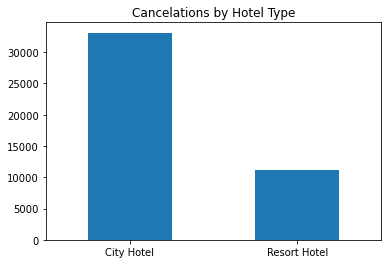

,Count,% of Canceled,% of Total
City Hotel,33102,74.85,27.73
Resort Hotel,11122,25.15,9.32


In [15]:
#Creating Bar Chart
hotel_bookings[canceled_bookings]['hotel'].value_counts().plot(kind='bar', title="Cancelations by Hotel Type")
plt.xticks(rotation=0)
plt.show()

#Creating DataFrame
htype_vcount = hotel_bookings[canceled_bookings]['hotel'].value_counts()

df_htvc = pd.DataFrame(htype_vcount)
df_htvc.columns = ['Count']

#Creating Percent of Canceled Bookings
can_pct = [round((i / canceled_count)*100, 2) for i in htype_vcount]

df_htvc['% of Canceled'] = can_pct

#Creating Percent of Total Bookings: Canceled & NonCanceled
tvc_pct = [round((i / total_bookings)*100, 2) for i in htype_vcount]

df_htvc['% of Total'] = tvc_pct

df_htvc


2. Canceled Bookings; **Distribution Channel**

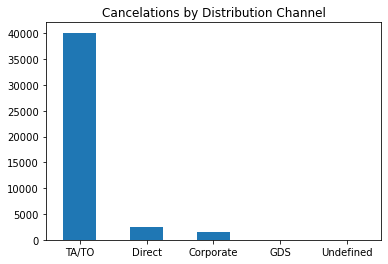

,Count,% of Canceled,% of Total
TA/TO,40152,90.79,33.63
Direct,2557,5.78,2.14
Corporate,1474,3.33,1.23
GDS,37,0.08,0.03
Undefined,4,0.01,0.00


In [16]:
#Creating Bar Chart
hotel_bookings[canceled_bookings]['distribution_channel'].value_counts().plot(kind='bar', title="Cancelations by Distribution Channel")
plt.xticks(rotation=0)
plt.show()

#Creating DataFrame
dc_vcount = hotel_bookings[canceled_bookings]['distribution_channel'].value_counts()

df_dcvc = pd.DataFrame(dc_vcount)
df_dcvc.columns = ['Count']

#Creating Percent of Canceled Bookings
can_pct = [round((i / canceled_count)*100, 2) for i in dc_vcount]

df_dcvc['% of Canceled'] = can_pct

#Creating Percent of Total Bookings: Canceled & NonCanceled
tvc_pct = [round((i / total_bookings)*100, 2) for i in dc_vcount]

df_dcvc['% of Total'] = tvc_pct

df_dcvc

3. Canceled Bookings; **Reserved Room Type**

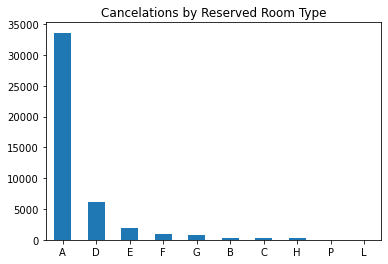

,Count,% of Canceled,% of Total
A,33630,76.04,28.17
D,6102,13.80,5.11
E,1914,4.33,1.60
F,880,1.99,0.74
G,763,1.73,0.64
B,368,0.83,0.31
C,308,0.70,0.26
H,245,0.55,0.21
P,12,0.03,0.01
L,2,0.00,0.00


In [17]:
#Creating Bar Chart
hotel_bookings[canceled_bookings]['reserved_room_type'].value_counts().plot(kind='bar', title="Cancelations by Reserved Room Type")
plt.xticks(rotation=0)
plt.show()

#Creating DataFrame
rt_vcount = hotel_bookings[canceled_bookings]['reserved_room_type'].value_counts()

df_rtvc = pd.DataFrame(rt_vcount)
df_rtvc.columns = ['Count']

#Creating Percent of Canceled Bookings
can_pct = [round((i / canceled_count)*100, 2) for i in rt_vcount]

df_rtvc['% of Canceled'] = can_pct

#Creating Percent of Total Bookings: Canceled & NonCanceled
tvc_pct = [round((i / total_bookings)*100, 2) for i in rt_vcount]

df_rtvc['% of Total'] = tvc_pct

df_rtvc

4. Canceled Bookings; **Deposit Type**

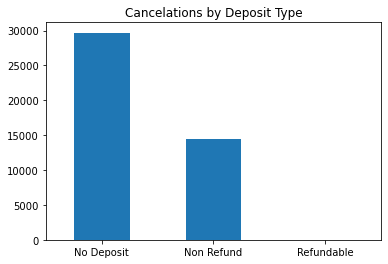

,Count,% of Canceled,% of Total
No Deposit,29694,67.14,24.87
Non Refund,14494,32.77,12.14
Refundable,36,0.08,0.03


In [18]:
#Creating Bar Chart
hotel_bookings[canceled_bookings]['deposit_type'].value_counts().plot(kind='bar', title="Cancelations by Deposit Type")
plt.xticks(rotation=0)
plt.show()

#Creating DataFrame
dt_vcount = hotel_bookings[canceled_bookings]['deposit_type'].value_counts()

df_dtvc = pd.DataFrame(dt_vcount)
df_dtvc.columns = ['Count']

#Creating Percent of Canceled Bookings
can_pct = [round((i / canceled_count)*100, 2) for i in dt_vcount]

df_dtvc['% of Canceled'] = can_pct

#Creating Percent of Total Bookings: Canceled & NonCanceled
tvc_pct = [round((i / total_bookings)*100, 2) for i in dt_vcount]

df_dtvc['% of Total'] = tvc_pct

df_dtvc

What's noteworthy here is that each level seems to have one entry that is a heavy majority. It would be interesting to watch the numbers within each majority to determine if there is one particular type of booking worth further exploration. 

## Further Investigating in "Count of Cancelations" by Issue Tree criteria

* Taking our above "heavy-favorite" observation into consideration, the next step is to take the same metrics and, this time, filter them based on that heavy favorite. 
* In other words, we will not only filter the total bookings by cancelations; we will continue to filter based on the previous "heavy favorite". 
* We will return a **bar chart** of each layer, but then a DataFrame with the following columns: Count, % of Filtered, % of Cancelations, % of Total Bookings.

1. Canceled Bookings; **Hotel Type**

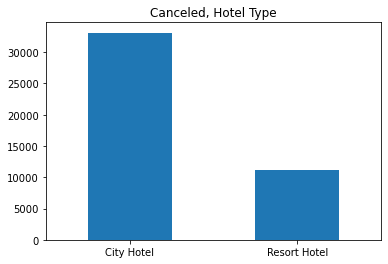

,Count,% of Filtered,% of Canceled,% of Total
City Hotel,33102,74.85,74.85,27.73
Resort Hotel,11122,25.15,25.15,9.32


In [19]:
#Creating Bar Chart
hotel_bookings[canceled_bookings]['hotel'].value_counts().plot(kind='bar', title="Canceled, Hotel Type")
plt.xticks(rotation=0)
plt.show()

#fc is going to represent the updated count within the filtered subset; fc=filtered_count
fc1 = hotel_bookings[canceled_bookings]['hotel'].count() 

#Creating DataFrame
htype_vcount = hotel_bookings[canceled_bookings]['hotel'].value_counts()

df_htvc = pd.DataFrame(htype_vcount)
df_htvc.columns = ['Count']

#Creating Percent of Filtered Bookings
fil_pct = [round((i / fc1)*100, 2) for i in htype_vcount]

df_htvc['% of Filtered'] = fil_pct

#Creating Percent of Canceled Bookings
can_pct = [round((i / canceled_count)*100, 2) for i in htype_vcount]

df_htvc['% of Canceled'] = can_pct

#Creating Percent of Total Bookings: Canceled & NonCanceled
tvc_pct = [round((i / total_bookings)*100, 2) for i in htype_vcount]

df_htvc['% of Total'] = tvc_pct

df_htvc

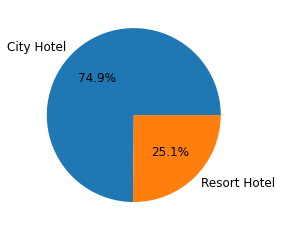

City Hotel      33102
Resort Hotel    11122
Name: hotel, dtype: int64


In [20]:
hotel_bookings[canceled_bookings]['hotel'].value_counts().plot(kind='pie', autopct='%1.1f%%', fontsize=12)
plt.ylabel("")
plt.savefig('hotel_type')
plt.show()
total_count = hotel_bookings[canceled_bookings]['hotel'].value_counts()
print(total_count)

These are repeat graphics; since this is the first layer of the the Issue Tree. Since City Hotels account for nearly 75% of all cancelations, we will add that layer and investigate Distribution based on Canceled, City Hotels. 

In order to do that, I'll create a variable so that we can filter out anything other than canceled, city bookings.

In [21]:
canceled_city_bookings = hotel_bookings[canceled_bookings]['hotel'] == 'City Hotel'

2. Canceled Bookings; Hotel Type; **Distribution Channel**

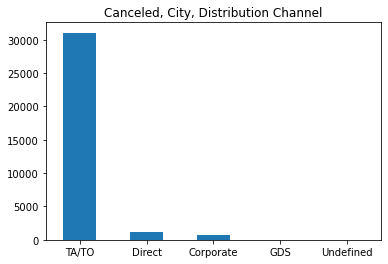

,Count,% of Filtered,% of Canceled,% of Total
TA/TO,31043,93.78,70.19,26.00
Direct,1232,3.72,2.79,1.03
Corporate,786,2.37,1.78,0.66
GDS,37,0.11,0.08,0.03
Undefined,4,0.01,0.01,0.00


In [22]:
#Creating Bar Chart
hotel_bookings[canceled_bookings][canceled_city_bookings]['distribution_channel'].value_counts().plot(kind='bar', title="Canceled, City, Distribution Channel")
plt.xticks(rotation=0)
plt.show()

#fc is going to represent the updated count within the filtered subset; fc=filtered_count
fc2 = hotel_bookings[canceled_bookings][canceled_city_bookings]['distribution_channel'].count() 

#Creating DataFrame
filter_vcount_2 = hotel_bookings[canceled_bookings][canceled_city_bookings]['distribution_channel'].value_counts()

df_filter_2 = pd.DataFrame(filter_vcount_2)
df_filter_2.columns = ['Count']

#Creating Percent of Filtered Bookings
fil_pct = [round((i / fc2)*100, 2) for i in filter_vcount_2]

df_filter_2['% of Filtered'] = fil_pct

#Creating Percent of Canceled Bookings
can_pct = [round((i / canceled_count)*100, 2) for i in filter_vcount_2]

df_filter_2['% of Canceled'] = can_pct

#Creating Percent of Total Bookings: Canceled & NonCanceled
tvc_pct = [round((i / total_bookings)*100, 2) for i in filter_vcount_2]

df_filter_2['% of Total'] = tvc_pct

df_filter_2

31,043 cancelations are city hotel via TA/TO distribution. Let's go another step into Reserved Room Type. But first, we will create a new variable to showcase Canceled, City, TA/TO bookings

In [23]:
canceled_city_tato_bookings = hotel_bookings[canceled_bookings][canceled_city_bookings]['distribution_channel'] == 'TA/TO'

3. Canceled Bookings; Hotel Type; Distribution Channel; **Room Type**

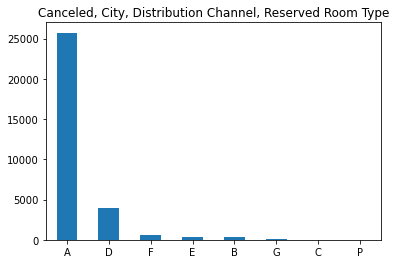

,Count,% of Filtered,% of Canceled,% of Total
A,25724,82.87,58.17,21.55
D,3900,12.56,8.82,3.27
F,657,2.12,1.49,0.55
E,353,1.14,0.80,0.30
B,320,1.03,0.72,0.27
G,83,0.27,0.19,0.07
C,4,0.01,0.01,0.00
P,2,0.01,0.00,0.00


In [24]:
#Creating Bar Chart
hotel_bookings[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings]['reserved_room_type'].value_counts().plot(kind='bar', title="Canceled, City, Distribution Channel, Reserved Room Type")
plt.xticks(rotation=0)
plt.show()

#fc is going to represent the updated count within the filtered subset; fc=filtered_count
fc3 = hotel_bookings[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings]['reserved_room_type'].count() 

#Creating DataFrame
filter_vcount_3 = hotel_bookings[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings]['reserved_room_type'].value_counts()

df_filter_3 = pd.DataFrame(filter_vcount_3)
df_filter_3.columns = ['Count']

#Creating Percent of Filtered Bookings
fil_pct = [round((i / fc3)*100, 2) for i in filter_vcount_3]

df_filter_3['% of Filtered'] = fil_pct

#Creating Percent of Canceled Bookings
can_pct = [round((i / canceled_count)*100, 2) for i in filter_vcount_3]

df_filter_3['% of Canceled'] = can_pct

#Creating Percent of Total Bookings: Canceled & NonCanceled
tvc_pct = [round((i / total_bookings)*100, 2) for i in filter_vcount_3]

df_filter_3['% of Total'] = tvc_pct

df_filter_3

Amazingly, of the total count of bookings, 25,714 (21.55%) cancelations are bookings for City Hotels via TA/TA distributions reserving Room Type A!

Let's go one more layer by adding Deposit Type.

4. Canceled Bookings; Hotel Type; Distribution Channel; Room Type; **Deposit Type**

In [25]:
canceled_city_tato_roomA_bookings = hotel_bookings[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings]['reserved_room_type'] == 'A'

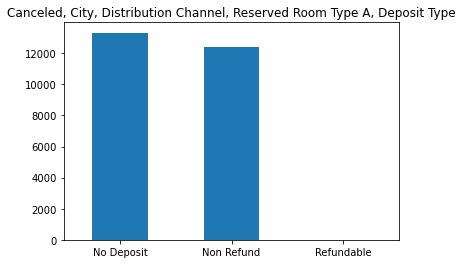

,Count,% of Filtered,% of Canceled,% of Total
No Deposit,13319,51.78,30.12,11.16
Non Refund,12398,48.20,28.03,10.38
Refundable,7,0.03,0.02,0.01


In [26]:
#Creating Bar Chart
hotel_bookings[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings]['deposit_type'].value_counts().plot(kind='bar', title="Canceled, City, Distribution Channel, Reserved Room Type A, Deposit Type")
plt.xticks(rotation=0)
plt.show()

#fc is going to represent the updated count within the filtered subset; fc=filtered_count
fc4 = hotel_bookings[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings]['deposit_type'].count() 

#Creating DataFrame
filter_vcount_4 = hotel_bookings[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings]['deposit_type'].value_counts()

df_filter_4 = pd.DataFrame(filter_vcount_4)
df_filter_4.columns = ['Count']

#Creating Percent of Filtered Bookings
fil_pct = [round((i / fc4)*100, 2) for i in filter_vcount_4]

df_filter_4['% of Filtered'] = fil_pct

#Creating Percent of Canceled Bookings
can_pct = [round((i / canceled_count)*100, 2) for i in filter_vcount_4]

df_filter_4['% of Canceled'] = can_pct

#Creating Percent of Total Bookings: Canceled & NonCanceled
tvc_pct = [round((i / total_bookings)*100, 2) for i in filter_vcount_4]

df_filter_4['% of Total'] = tvc_pct

df_filter_4


No "heavy favorite" here. "No Deposit" and "Non Refund" are about equal; however "Refundable" deposits occur only 7 times within this grouping. This could have been interesting, but we learned in our initial look that only 36 of the total bookings were refundable deposits. 

### **At this point, let's back up a step and leave this investigation with a Canceled, City, TA/TO, Room Type A Filtered Subset!** 

## <u> Part 3: Exploratory Data Analysis</u>

In a sense, the title of this "part" is a bit of a misnomer. We have been exploring the data. But, in this part we will begin using statistical tools and visualizations to look at the data. For example, Box Plots.

This exploration will investigate how bookings the previously identified "Filtered Subset" differ from "Other Cancelations"; and how they differ from "Noncancelations". Perhaps differences in the patterns will help identify which variables are possible drivers.

## Boxplot work

We're considered with numerical data; so any categorical or boolean data is dropped. 

In [27]:
listofvariables = hotel_bookings.drop(['is_canceled','hotel','meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company', 'customer_type', 'reservation_status', 'reservation_status_date', 'arrival_date', 'res_status_date', 'required_car_parking_spaces', 'arrival_date_month', 'labeled_is_canceled'], axis=1).columns

The next 2 blocks of code creates a way to distinguish between "Filtered" and "Other" within Canceled Bookings.

In [28]:
def filter_conditions(hotel_bookings):
    if (hotel_bookings['is_canceled'] == 1) and (hotel_bookings['hotel'] == 'City Hotel') and (hotel_bookings['distribution_channel'] == 'TA/TO') and (hotel_bookings['reserved_room_type'] == 'A'):
        return 1
    else:
        return 0
    
hotel_bookings['cancel_filter'] = hotel_bookings.apply(filter_conditions, axis=1)

In [29]:
Cancelation_NonFiltered = hotel_bookings['cancel_filter'] == 0

Finally, a side by side by side look at boxplot visualizations among bookings that were "Not Canceled", "Other Cancelation", and "Filtered Subset"

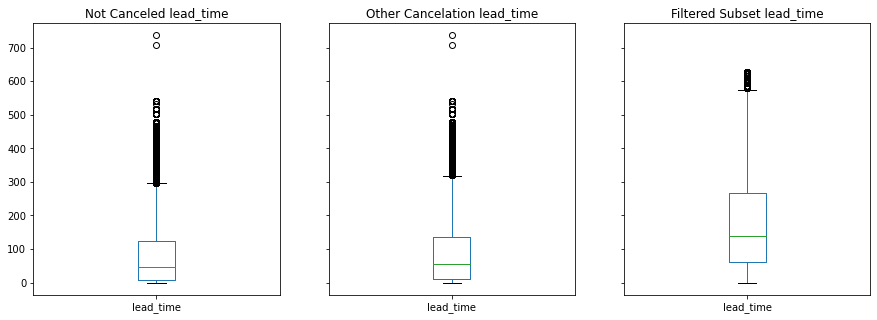

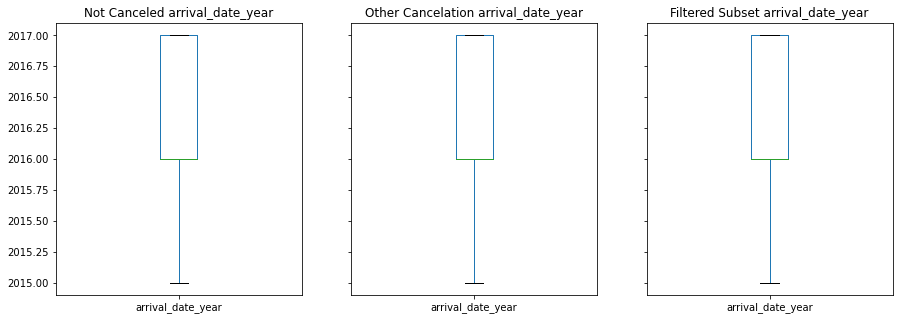

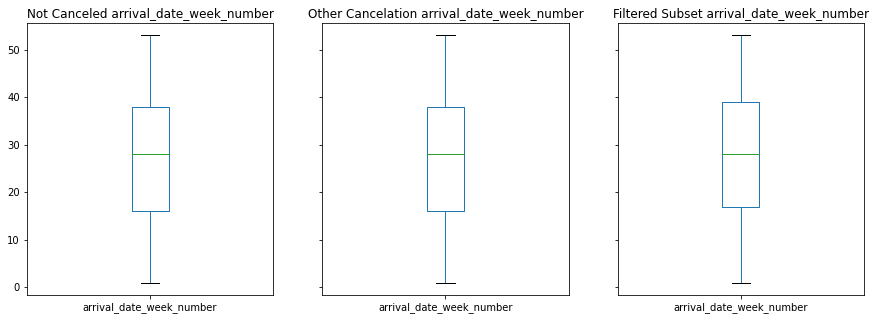

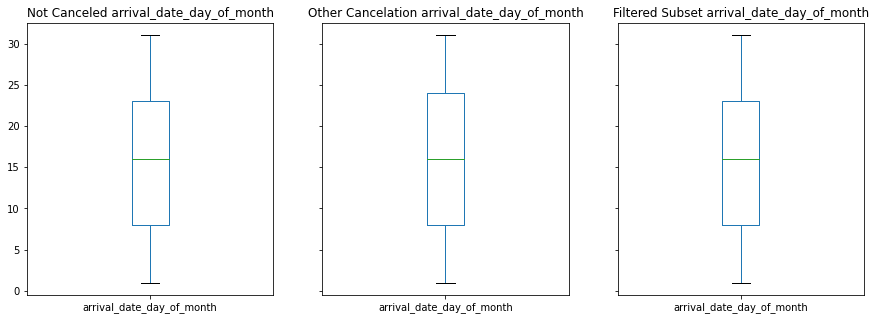

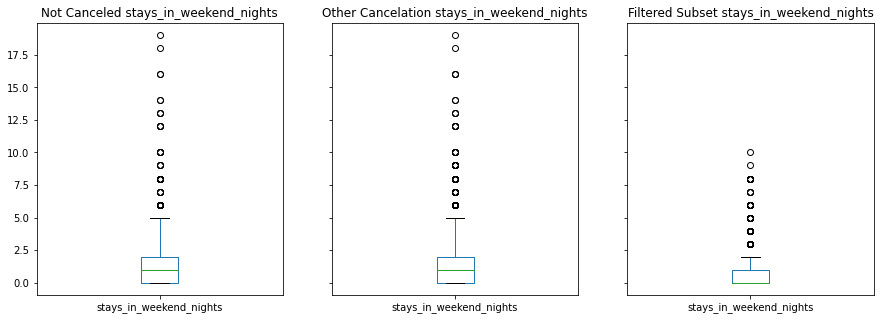

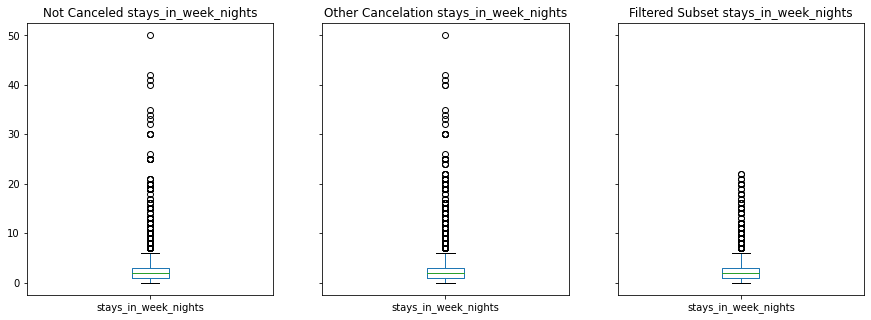

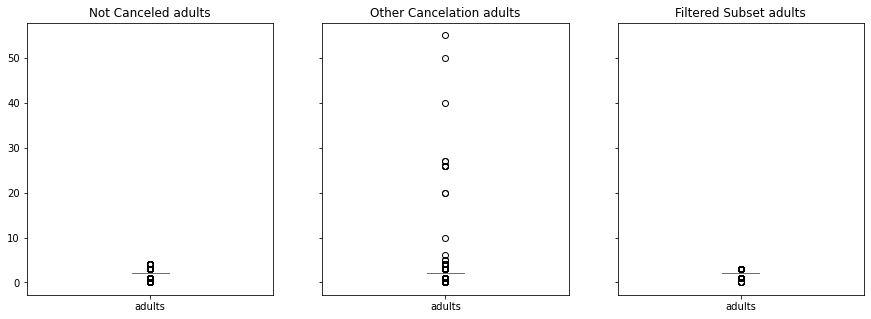

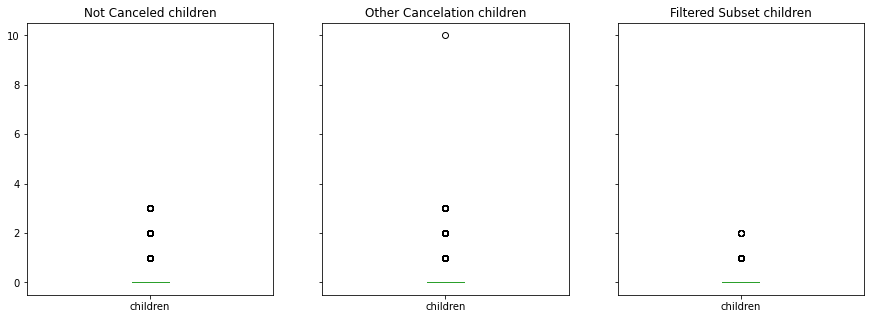

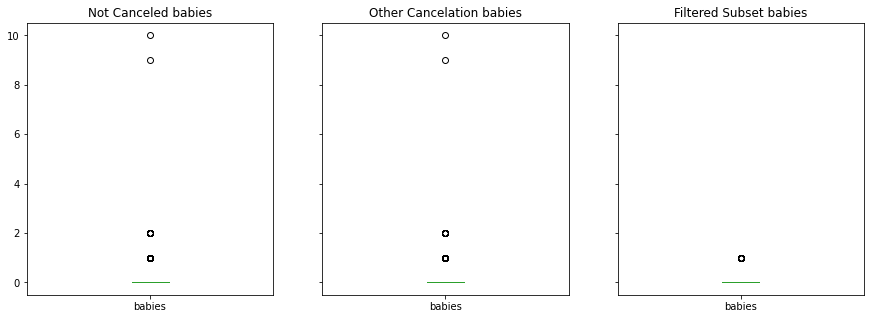

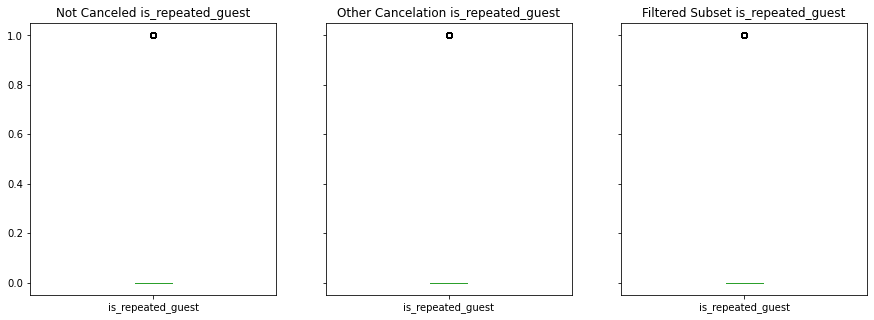

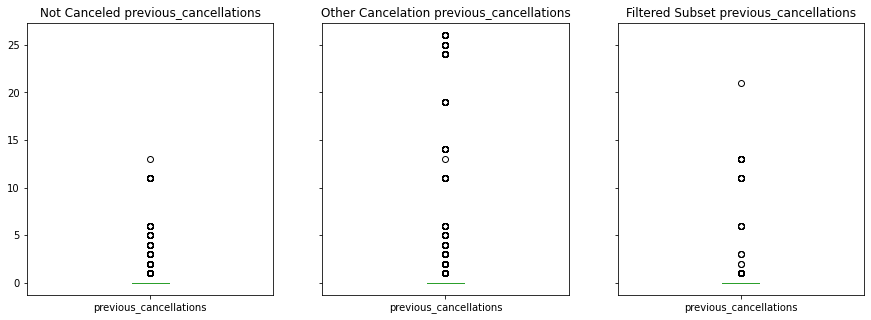

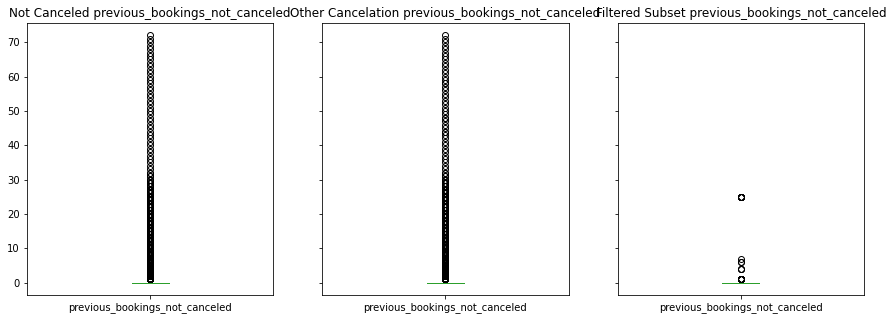

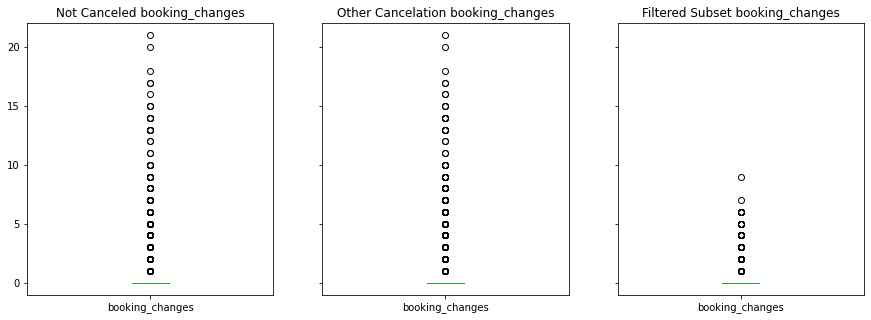

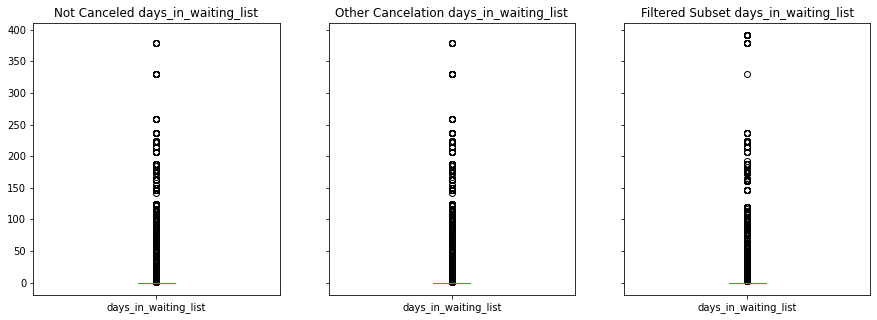

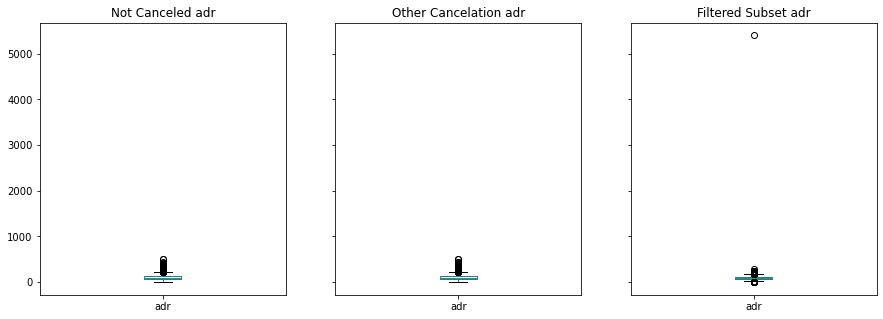

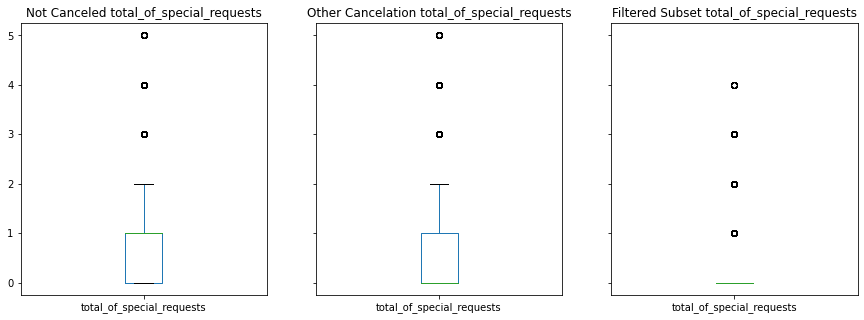

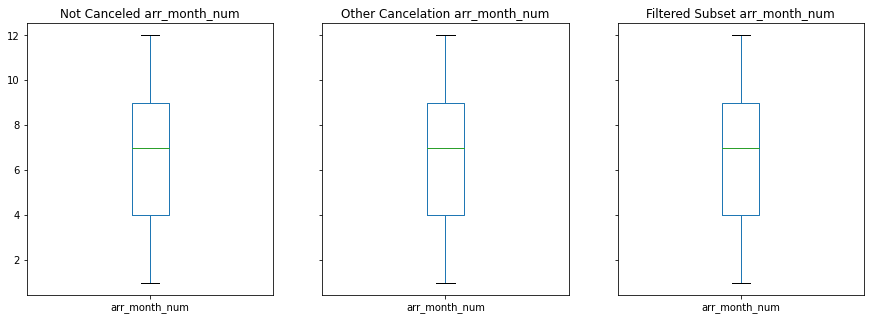

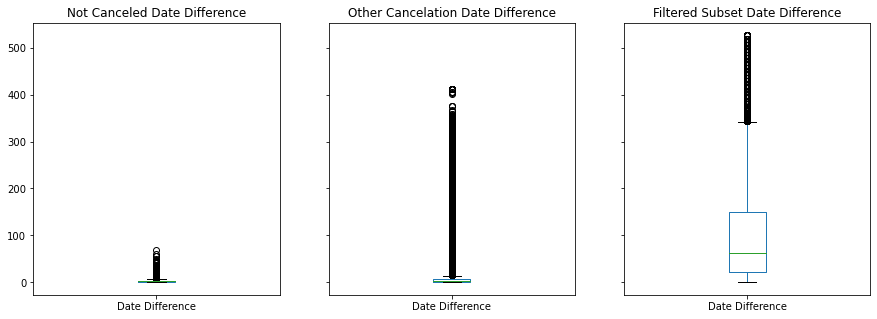

In [30]:
for i in listofvariables:
    fig, axes = plt.subplots(1,3,sharey=True, figsize=(15,5))
    hotel_bookings[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
    axes[0].set_title("Not Canceled " + i)
    hotel_bookings[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
    axes[1].set_title("Other Cancelation " + i)
    hotel_bookings[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])
    axes[2].set_title("Filtered Subset " + i)
    
    plt.show()

Having identified a few images of interest; this code saves images for particular variables.

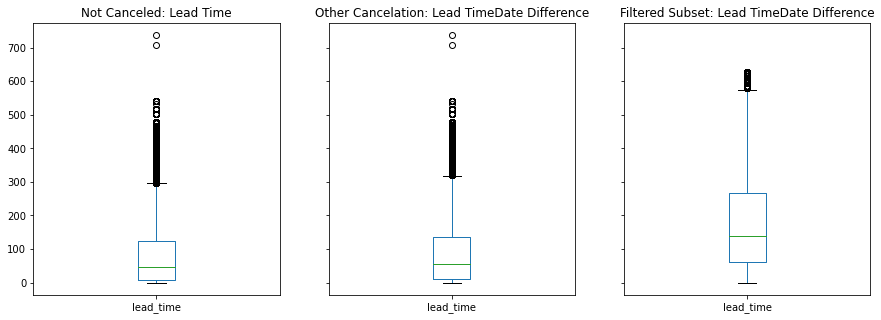

In [31]:
fig, axes = plt.subplots(1,3,sharey=True, figsize=(15,5))

hotel_bookings[noncanceled_bookings]['lead_time'].plot(kind='box', ax=axes[0])
axes[0].set_title("Not Canceled: Lead Time")

hotel_bookings[Cancelation_NonFiltered]['lead_time'].plot(kind='box', ax=axes[1])
axes[1].set_title("Other Cancelation: Lead Time" + i)

hotel_bookings[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings]['lead_time'].plot(kind='box', ax=axes[2])
axes[2].set_title("Filtered Subset: Lead Time" + i)

plt.savefig("Lead Time Boxplots")
plt.show()

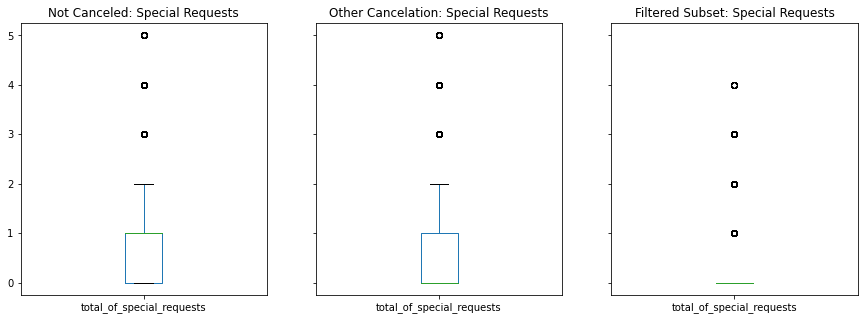

In [32]:
fig, axes = plt.subplots(1,3,sharey=True, figsize=(15,5))

hotel_bookings[noncanceled_bookings]['total_of_special_requests'].plot(kind='box', ax=axes[0])
axes[0].set_title("Not Canceled: Special Requests")

hotel_bookings[Cancelation_NonFiltered]['total_of_special_requests'].plot(kind='box', ax=axes[1])
axes[1].set_title("Other Cancelation: Special Requests")

hotel_bookings[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings]['total_of_special_requests'].plot(kind='box', ax=axes[2])
axes[2].set_title("Filtered Subset: Special Requests")

plt.savefig("Special Request Boxplots")
plt.show()

## Boxplots without Outliers

**Identify Outliers**

The above boxplot worked revealed a significant outlier within the 'adr' or 'average daily rate' column. By removing this outlier and looking at the boxplot we can determine if 'adr' is a potential driver.

In [33]:
withoutoutlier = hotel_bookings[hotel_bookings['adr']<3000]

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


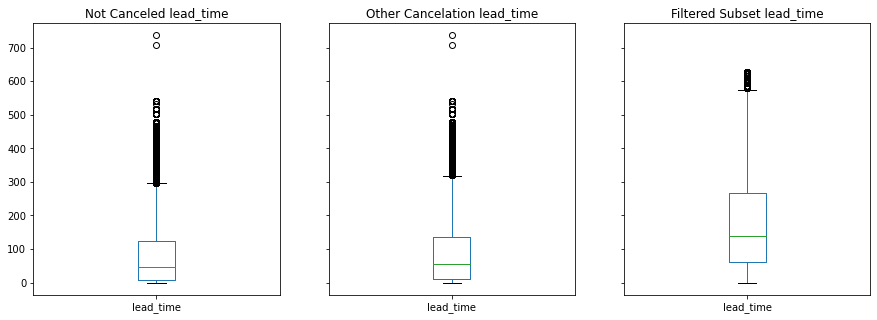

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


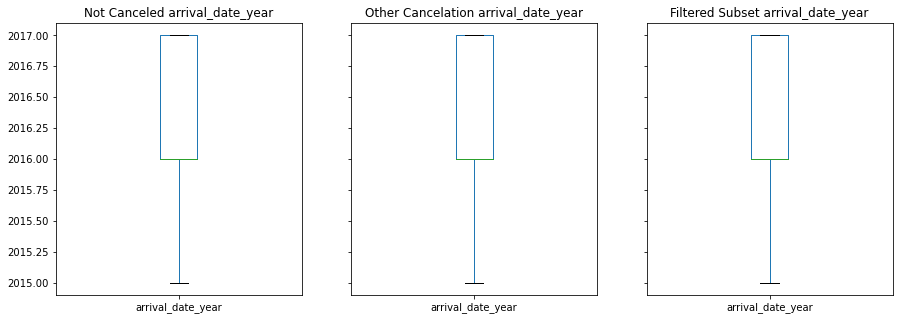

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


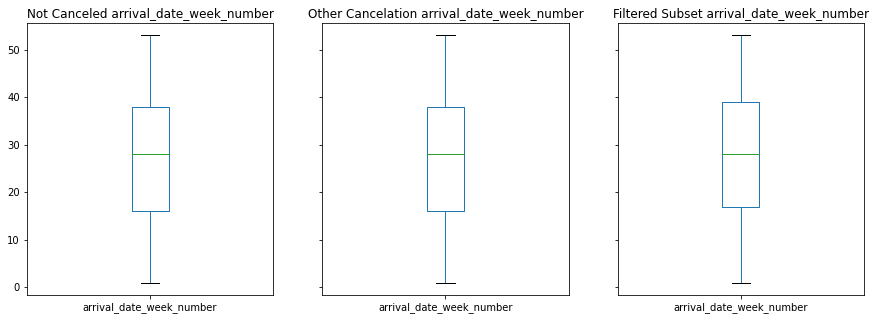

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


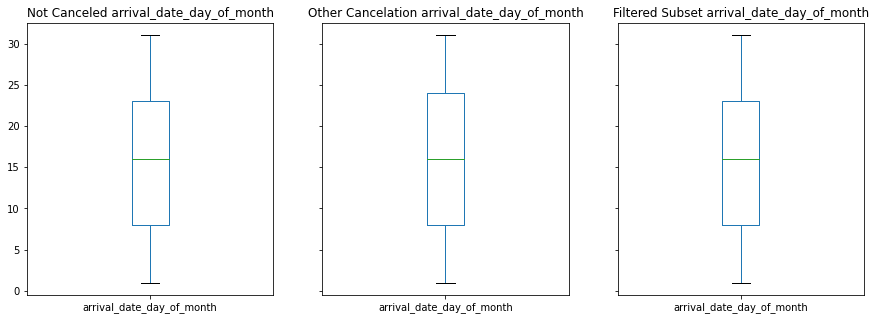

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


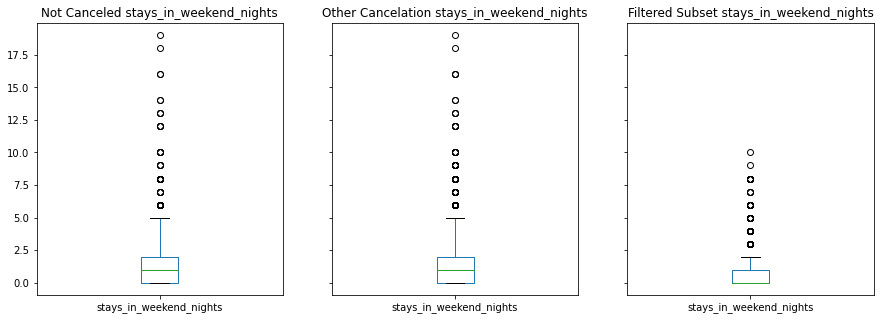

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


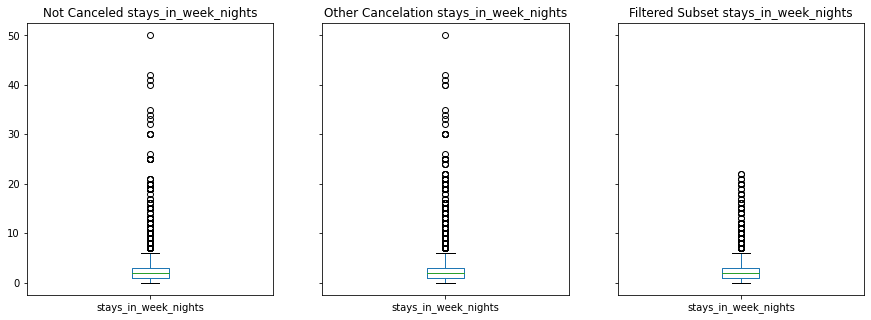

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


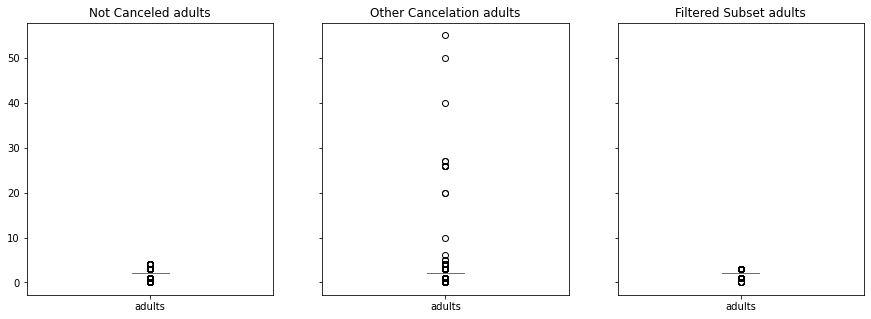

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


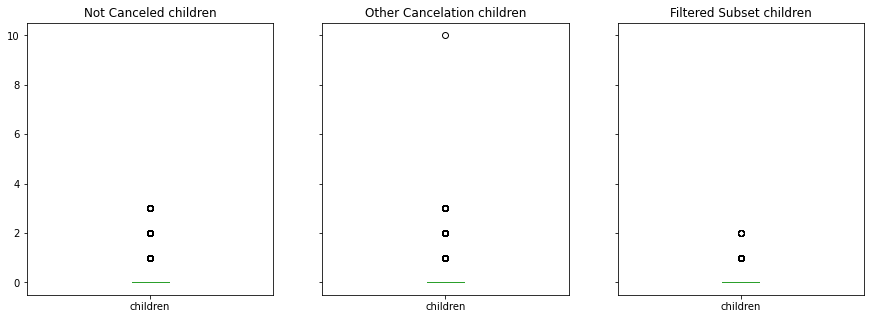

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


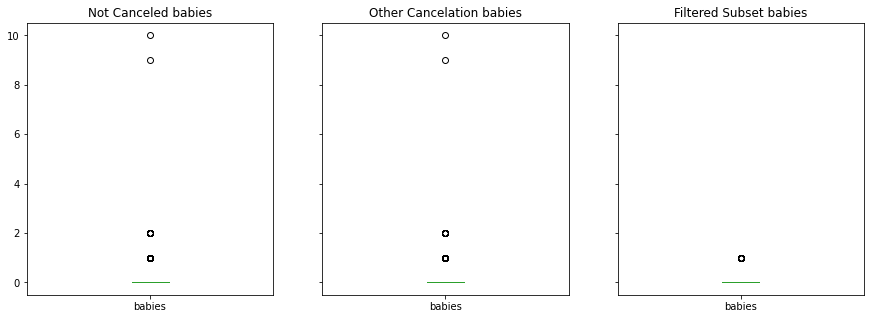

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


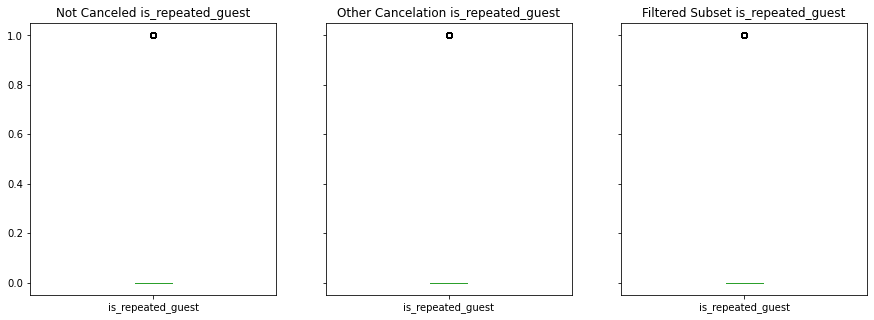

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


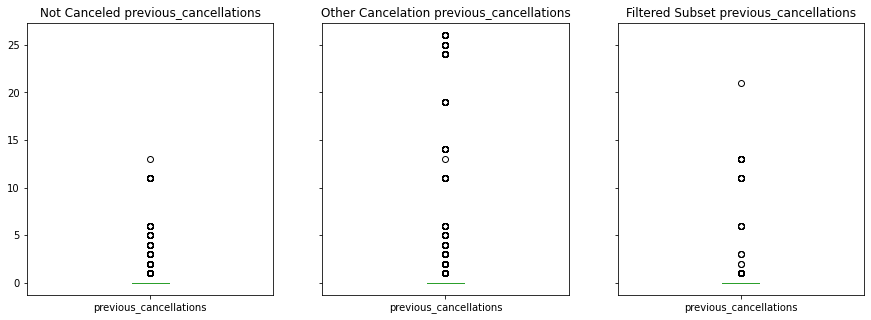

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


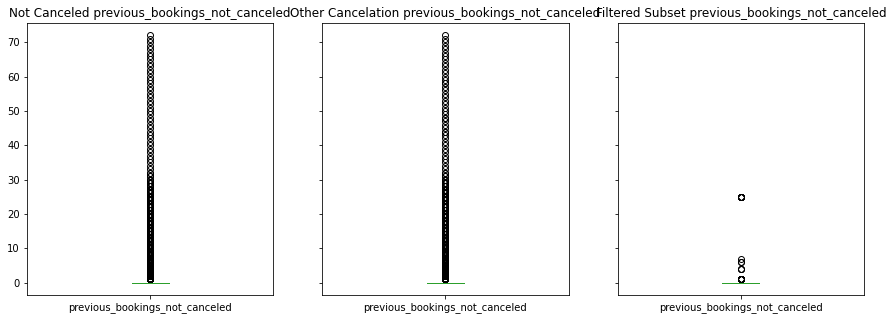

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


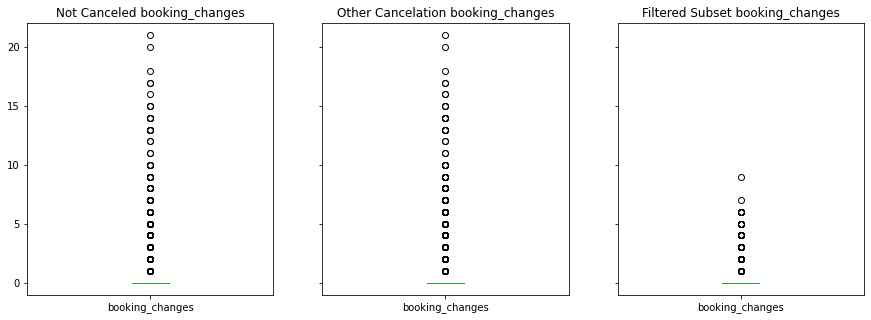

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


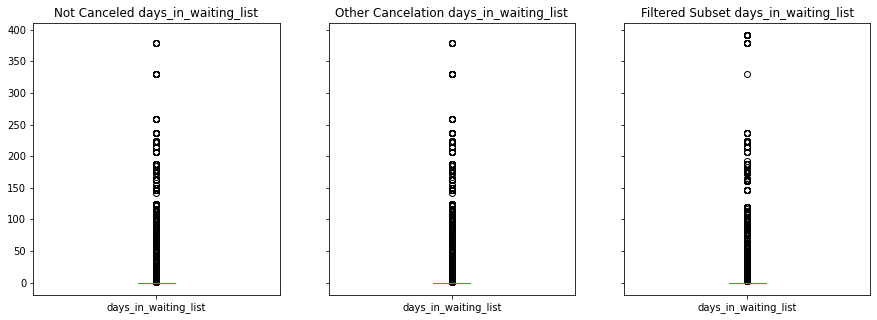

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


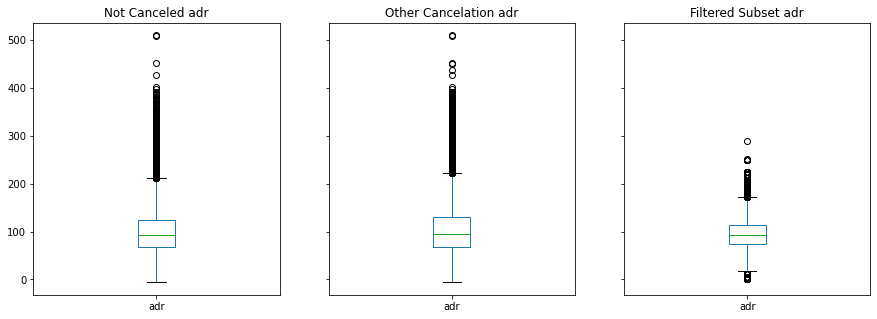

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


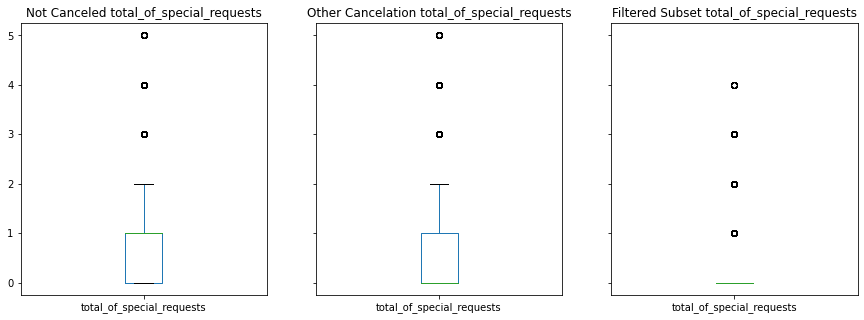

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


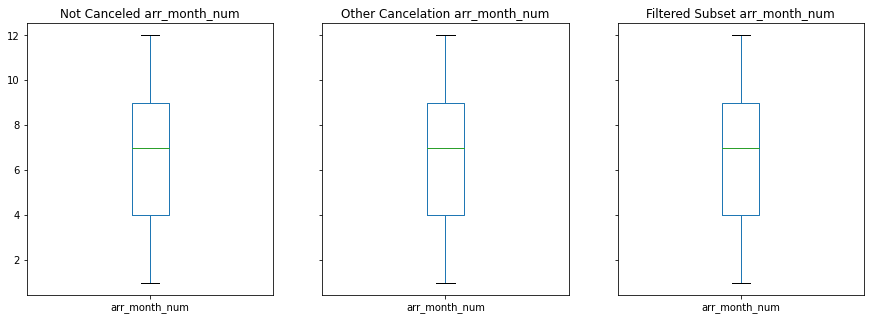

<ipython-input-34-32ddeb774e1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
<ipython-input-34-32ddeb774e1e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
<ipython-input-34-32ddeb774e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])


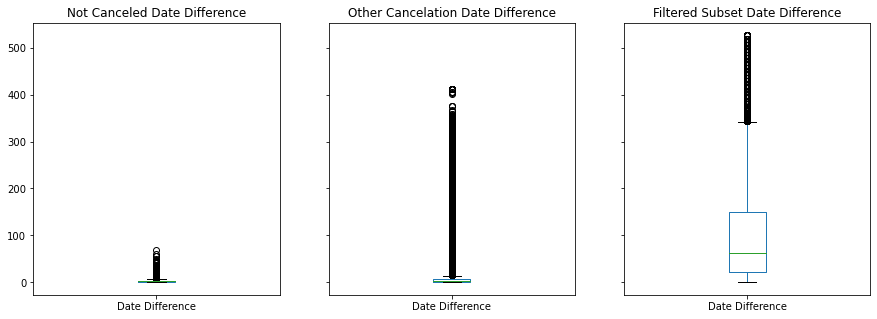

In [34]:
for i in listofvariables:
    fig, axes = plt.subplots(1,3,sharey=True, figsize=(15,5))
    withoutoutlier[noncanceled_bookings][i].plot(kind='box', ax=axes[0])
    axes[0].set_title("Not Canceled " + i)
    withoutoutlier[Cancelation_NonFiltered][i].plot(kind='box', ax=axes[1])
    axes[1].set_title("Other Cancelation " + i)
    withoutoutlier[canceled_bookings][canceled_city_bookings][canceled_city_tato_bookings][canceled_city_tato_roomA_bookings][i].plot(kind='box', ax=axes[2])
    axes[2].set_title("Filtered Subset " + i)
    
    plt.show()

## <u>Findings so far:</u>

## 1 out of 5 total bookings will result in a canceled bookings from a city hotel via market distribution TA/TO reserving Room Type A.

### What is driving such high cancelation numbers from this kind of booking?

#### Let's start with a correlation heat map for all cancelations

Creating a list of variables for the heatmap.

In [35]:
hm_variables = hotel_bookings.drop(['Date Difference','hotel','meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company', 'customer_type', 'reservation_status', 'reservation_status_date', 'arrival_date_month', 'arrival_date', 'res_status_date', 'required_car_parking_spaces', 'cancel_filter'], axis=1).corr()

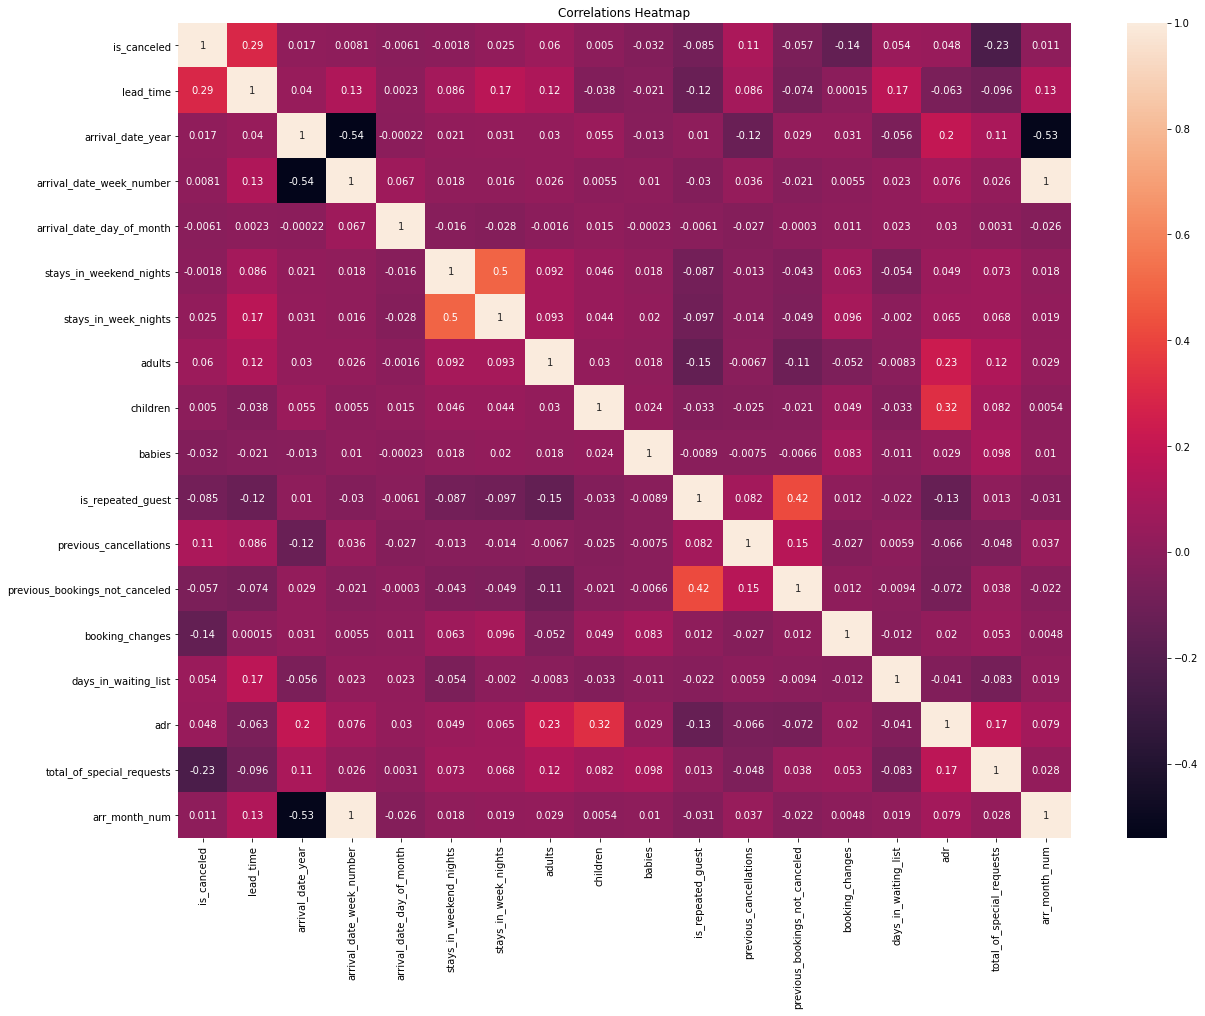

In [36]:
plt.subplots(figsize=(20,15))
sns.heatmap(hm_variables, annot=True)
plt.title('Correlations Heatmap')
plt.show()

This visualization allows us to see correlation of variables to cancelations sorted from positive 1 to negative -1.

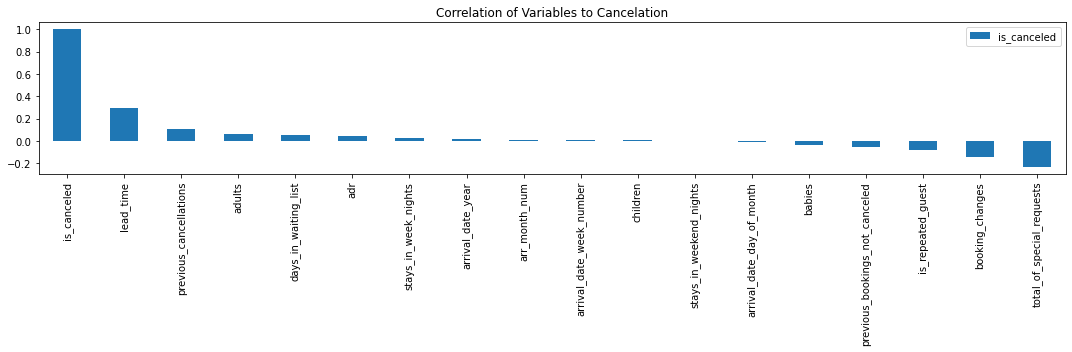

In [37]:
sorted_variables = hm_variables.sort_values('is_canceled', ascending=False)
sorted_variables[['is_canceled']].plot(kind='bar', title="Correlation of Variables to Cancelation", figsize=(15,5))
plt.tight_layout()
plt.savefig("correlation_bar")

# Identification & Exploration of Potential Drivers

I want to find some additional statistical information, such as the mean, of some potential key drivers to find how the variables differ within our Filtered Subset, Other Cancelations, and Noncancelations. Here I also made visualizations for my presentation.

This below list of variables only includes those considered to be "Potential Drivers" based on the above analysis.
1. Lead Time
2. Weekend Nights per Stay
3. Weekday Nights per Stay
4. Average Daily Rate (adr)
5. Number of Special Requests
6. Cancelation Notice (Date Difference)

In [38]:
potential_drivers = hotel_bookings.drop(['hotel', 'is_canceled', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel','previous_bookings_not_canceled', 'is_repeated_guest', 'previous_cancellations', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'agent', 'deposit_type','company', 'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces', 'reservation_status', 'reservation_status_date', 'labeled_is_canceled', 'arr_month_num', 'arrival_date', 'res_status_date', 'cancel_filter'], axis=1).columns

I created a column here that categorized each booking into one of 3 subsets. This allowed me to search for patterns based on the subset.

Also created a pie chart to show how each subset represents a part of all bookings.

In [39]:
def compare_groups(hotel_bookings):
    if (hotel_bookings['is_canceled'] == 1) and (hotel_bookings['hotel'] == 'City Hotel') and (hotel_bookings['distribution_channel'] == 'TA/TO') and (hotel_bookings['reserved_room_type'] == 'A'):
        return "Filtered Subset"
    if (hotel_bookings['is_canceled'] == 0):
        return "Noncancelation"
    else:
        return "Other Cancelation"
    
hotel_bookings['compare_groups'] = hotel_bookings.apply(compare_groups, axis=1)

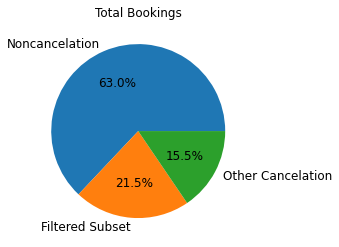

In [40]:
hotel_bookings['compare_groups'].value_counts().plot(kind='pie', autopct='%1.1f%%', fontsize=12, title="Total Bookings")
plt.ylabel("")
plt.savefig("Compare Groups")
plt.show()

Created a way to refer to each subset.

In [41]:
filtered_subset = hotel_bookings['compare_groups'] == 'Filtered Subset'
noncancelations = hotel_bookings['compare_groups'] == 'Noncancelation'
other_cancelation = hotel_bookings['compare_groups'] == 'Other Cancelation'

Comparison of the **Mean** within each of the 3 subsets of data.

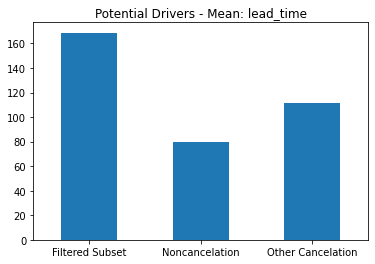

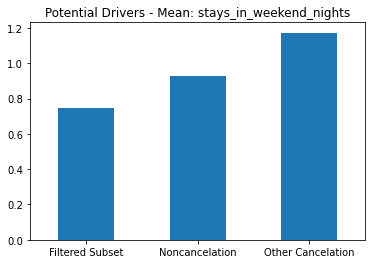

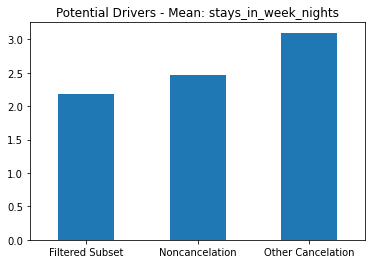

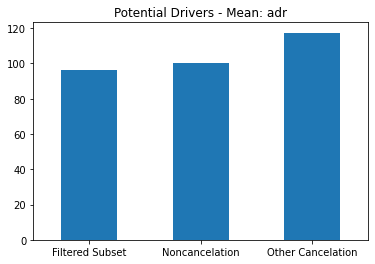

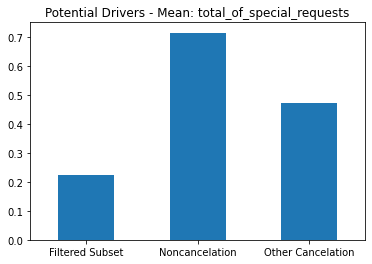

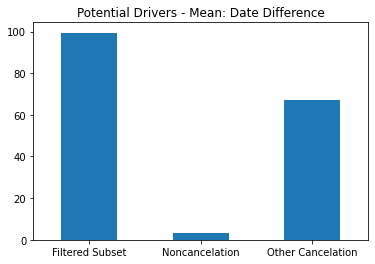

In [42]:
for i in potential_drivers:
    driver_mean = hotel_bookings.groupby('compare_groups')[i].mean()
    driver_mean.plot(kind='bar', title="Potential Drivers - Mean: " + i)
    plt.xticks(rotation=0)
    plt.xlabel("")
    plt.show()
    

Comparison of the **Median** within each of the 3 subsets of data.

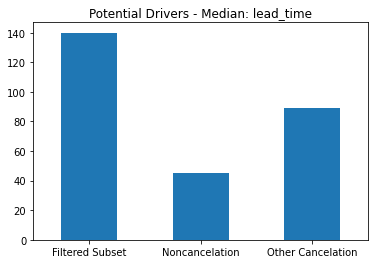

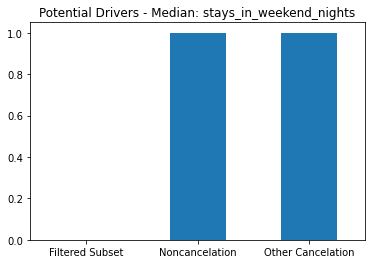

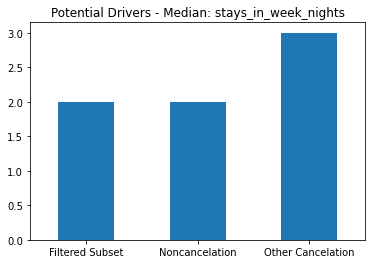

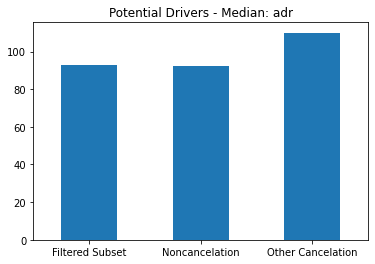

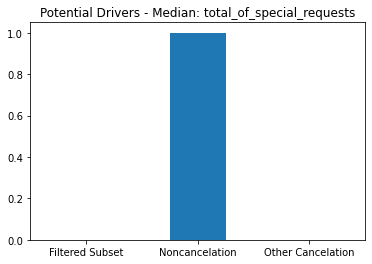

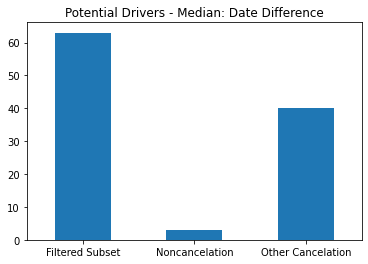

In [43]:
for i in potential_drivers:
    driver_median = hotel_bookings.groupby('compare_groups')[i].median()
    driver_median.plot(kind='bar', title="Potential Drivers - Median: " + i)
    plt.xticks(rotation=0)
    plt.xlabel("")
    plt.show()

### 1. Deeper look at the mean and median of "Lead Time".

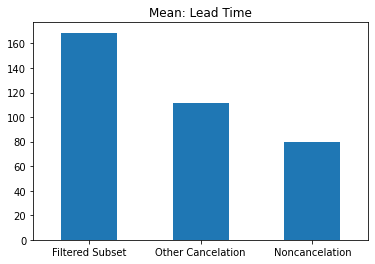

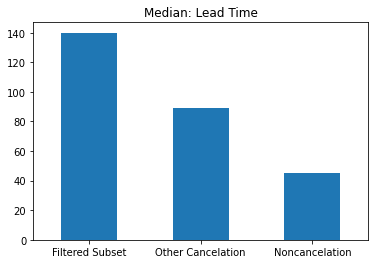

In [44]:
lead_mean = hotel_bookings.groupby('compare_groups')['lead_time'].mean().sort_values(ascending=False)
lead_mean.plot(kind='bar', title="Mean: Lead Time")
plt.xticks(rotation=0)
plt.xlabel("")
plt.savefig("Lead Time Mean")
plt.show()

lead_median = hotel_bookings.groupby('compare_groups')['lead_time'].median().sort_values(ascending=False)
lead_median.plot(kind='bar', title="Median: Lead Time")
plt.xticks(rotation=0)
plt.xlabel("")
plt.savefig("Lead Time Median")
plt.show()

### 2. Deeper look at the mean and median of "Special Requests".

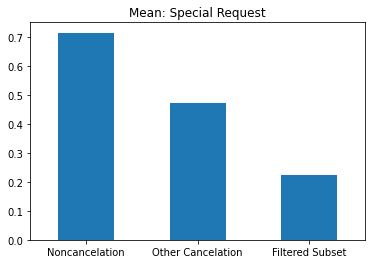

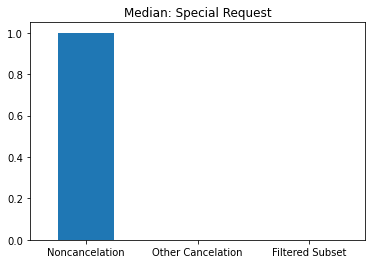

In [45]:
lead_mean = hotel_bookings.groupby('compare_groups')['total_of_special_requests'].mean().sort_values(ascending=False)
lead_mean.plot(kind='bar', title="Mean: Special Request")
plt.xticks(rotation=0)
plt.xlabel("")
plt.savefig("Special Request Mean")
plt.show()

lead_median = hotel_bookings.groupby('compare_groups')['total_of_special_requests'].median().sort_values(ascending=False)
lead_median.plot(kind='bar', title="Median: Special Request")
plt.xticks(rotation=0)
plt.xlabel("")
plt.savefig("Special Request Median")
plt.show()

### 3. Deeper look at the median of "Cancelation Notice".

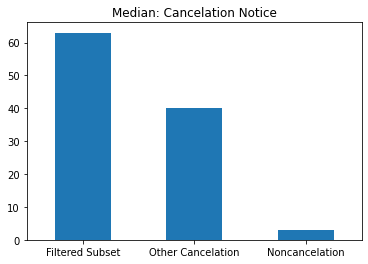

In [46]:
notice_median = hotel_bookings.groupby('compare_groups')['Date Difference'].median().sort_values(ascending=False)
notice_median.plot(kind='bar', title="Median: Cancelation Notice")
plt.xticks(rotation=0)
plt.xlabel("")
plt.savefig("Cancelation Notice Mean")
plt.show()

The below histogram shows distribution of lead time for all bookings and then for the filtered subset.

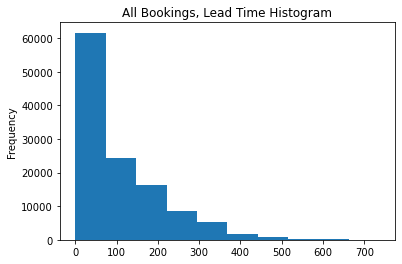

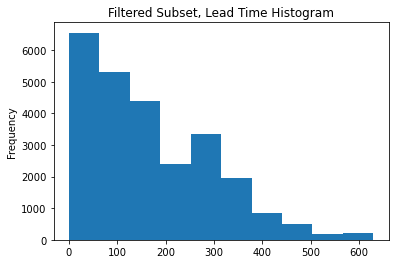

In [47]:
lead_hist_all = hotel_bookings['lead_time'].plot(kind='hist', title="All Bookings, Lead Time Histogram")
plt.xticks(rotation=0)
plt.xlabel("")
plt.show()

lead_hist = hotel_bookings[filtered_subset]['lead_time'].plot(kind='hist', title="Filtered Subset, Lead Time Histogram")
plt.xticks(rotation=0)
plt.xlabel("")
plt.show()

### 4. Deeper look at "Repeated Guest".

1. **Count** of New Guest v. Repeated Guest among the Filtered Subset
2. Comparison of **Mean** among the 3 subsets


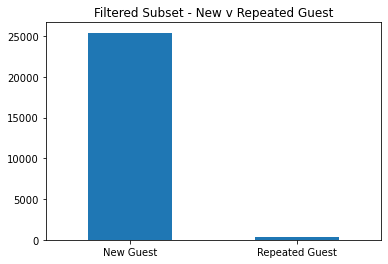

In [48]:
#Creating the Bar Graph
hotel_bookings[filtered_subset]['is_repeated_guest'].value_counts().plot(kind='bar', title="Filtered Subset - New v Repeated Guest")
plt.xticks((0, 1), ('New Guest', 'Repeated Guest'),rotation=0)
plt.savefig("Filtered Repeated Guest")
plt.show()


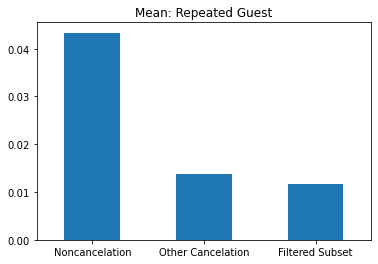

In [49]:
newguest_mean = hotel_bookings.groupby('compare_groups')['is_repeated_guest'].mean().sort_values(ascending=False)
newguest_mean.plot(kind='bar', title="Mean: Repeated Guest")
plt.xticks(rotation=0)
plt.xlabel("")
plt.savefig("Repeated Guest Mean")
plt.show()

## Monetary Considerations

In considering what is driving cancelations, it occured a good idea to take a look at what is at stake. How much potential income is lost by cancelations? What kind of income could be made by converting an additional 5% or 10% of bookings?

Determining the income per stay, a column was created which took the average daily rate for the booking and multiplied it by the total nights stayed. This gave an approximate total for each particular booking. 

* Now this isn't a completely accurate metric. There are quite a few missing pieces of information for an accurate financial analysis. However, this will at least give a ballpark estimate that looks at these insights through a monetary lens.

In [50]:
hotel_bookings['stay_income'] = hotel_bookings['adr'] * (hotel_bookings['stays_in_weekend_nights'] + hotel_bookings['stays_in_week_nights'])

Total income would include both actual income from non-canceled stays and the potential income from an eventually canceled stay.

This will prove useful when determining how much income is lost by cancelations. 


In [51]:
total_income = hotel_bookings['stay_income'].sum()
print(total_income)

42723497.53


This is income lost due cancelations within the Filtered Subset.

In [52]:
filtered_income = hotel_bookings[filtered_subset]['stay_income'].sum()
print(filtered_income)

7322295.2


This is income from Noncanceled bookings that follow the same remaining crieteria of the Filtered Subset. In other words, the same rooms, from the same channels, within the same hotels.

In [53]:
#Income from Noncanceled bookings that follow the remaining filtered subset criteria
def filtered_income(hotel_bookings):
    if (hotel_bookings['is_canceled'] == 0) and (hotel_bookings['hotel'] == 'City Hotel') and (hotel_bookings['distribution_channel'] == 'TA/TO') and (hotel_bookings['reserved_room_type'] == 'A'):
        return "1"
    else:
        return "0"

hotel_bookings['filtered_income'] = hotel_bookings.apply(filtered_income, axis=1)

f_income = hotel_bookings['filtered_income'] == "1"

f_income_sum = hotel_bookings[f_income]['stay_income'].sum()
print(f_income_sum)

8330443.18


The amount of additional income if 5% or 10% of cancelations within the Filtered Subset were converted into stays.

In [54]:
fivepct = filtered_income * 0.05
print("Converting 5% more bookings into stay within the Filtered Subset would result in $" + str(fivepct) + " in additional income.")

tenpct = filtered_income * 0.1
print("Converting 10% more bookings into stay within the Filtered Subset would result in $" + str(tenpct) + " in additional income.")

TypeError: unsupported operand type(s) for *: 'function' and 'float'

### Fiscal Year 

As it is, the dates within this data set correspond to the calendar year. As a company, we are interested in the fiscal year from July 1 until June 30. This code will place the bookings into their respective fiscal year.

In [55]:
def fiscal_year(hotel_bookings):
    if ((hotel_bookings['arrival_date'] > np.datetime64('2015-07-01')) & (hotel_bookings['arrival_date'] < np.datetime64('2016-06-30'))): 
        return "2015-2016"
    if ((hotel_bookings['arrival_date'] > np.datetime64('2016-07-01')) & (hotel_bookings['arrival_date'] < np.datetime64('2017-06-30'))):
        return "2016-2017"
    else:
        return "2017-2018"
    
hotel_bookings['fiscal_year'] = hotel_bookings.apply(fiscal_year, axis=1)

Income by Fiscal Year, separated by Canceled and Noncanceled. In that regard, actual income vs potential/lost income.

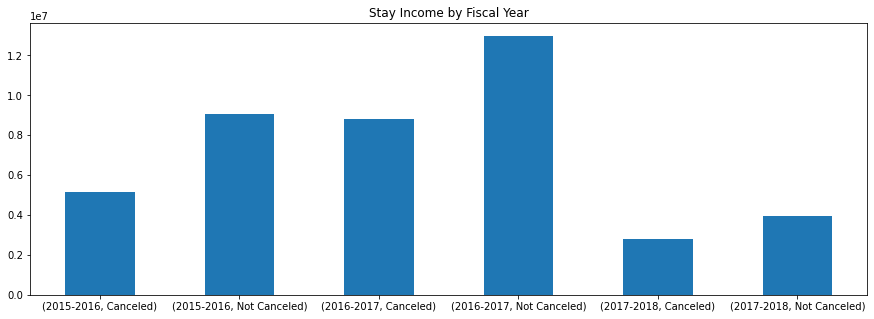

In [56]:
yearly_income = hotel_bookings.groupby(['fiscal_year','labeled_is_canceled'])['stay_income'].sum()
yearly_income.plot(kind='bar', title="Stay Income by Fiscal Year", figsize=(15, 5))
plt.xticks(rotation=0)
plt.xlabel("")
plt.savefig("stay income by fiscal year")
plt.show()

A total of actual income regardless of year vs lost income via cancelations. 

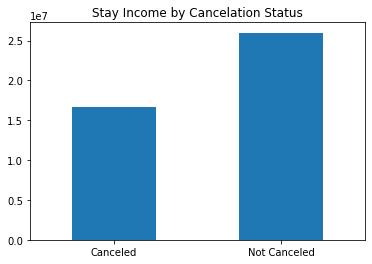

In [57]:
canceled_noncanceled_income = hotel_bookings.groupby('labeled_is_canceled')['stay_income'].sum()
canceled_noncanceled_income.plot(kind='bar', title="Stay Income by Cancelation Status")
plt.xticks(rotation=0)
plt.xlabel("")
plt.savefig("stay income by cancel status")
plt.show()

Potential Income via Cancelations for Filtered Subset vs Other Cancelations

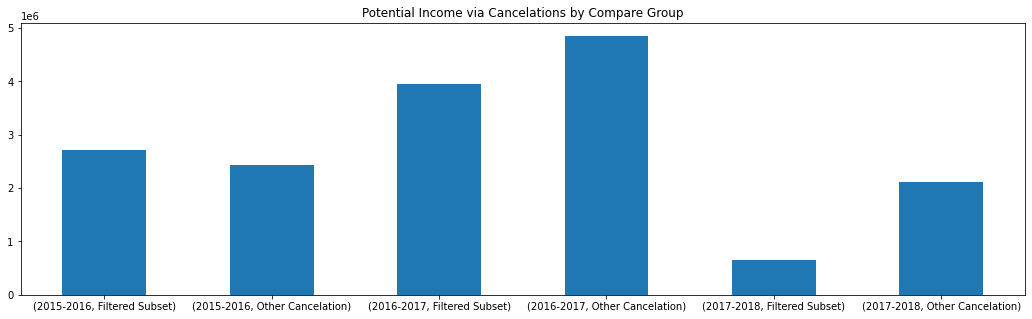

In [58]:
compare_group_income = hotel_bookings[canceled_bookings].groupby(['fiscal_year', 'compare_groups'])['stay_income'].sum()
compare_group_income.plot(kind='bar', title="Potential Income via Cancelations by Compare Group", figsize=(18,5))
plt.xticks(rotation=0)
plt.xlabel("")
plt.savefig("potential income cancel compare group")
plt.show()